In [1]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [92]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from toai.imports import *
from toai.data import DataContainer, DataBundle
from toai.data.utils import balance_df_labels
from gpu_helper import enable_gpu
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from model_utils import *

<IPython.core.display.Javascript object>

In [6]:
enable_gpu()

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


<IPython.core.display.Javascript object>

In [7]:
tf.get_logger().setLevel("ERROR")

<IPython.core.display.Javascript object>

In [9]:
DATA_DIR = Path("data")
TEMP_DIR = Path("temp")
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

<IPython.core.display.Javascript object>

In [10]:
df = pd.read_json(DATA_DIR / "stupidstuff.json")

<IPython.core.display.Javascript object>

In [11]:
df.head()

,body,category,id,rating
0,A blackjack dealer and a player with a thirtee...,Children,1,2.63
1,"At a dinner party, several of the guests were ...",Blonde Jokes,2,2.57
2,One day this cop pulls over a blonde for speed...,Blonde Jokes,3,3.09
3,Three women are about to be executed for crime...,Blonde Jokes,4,4.10
4,A girl came skipping home FROM school one day....,Blonde Jokes,5,4.30


<IPython.core.display.Javascript object>

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3773 entries, 0 to 3772
Data columns (total 4 columns):
body        3773 non-null object
category    3773 non-null object
id          3773 non-null int64
rating      3773 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 118.0+ KB


<IPython.core.display.Javascript object>

In [13]:
df[df["body"] == ""]

,body,category,id,rating
1728,,Science,1729,4.5
1937,,Miscellaneous,1938,3.0
2949,,Animals,2950,2.0
2952,,Animals,2953,4.0
2953,,Animals,2954,5.0
...,...,...,...,...
3763,,Miscellaneous,3764,3.0
3766,,Miscellaneous,3767,4.0
3767,,Miscellaneous,3768,3.0
3768,,Miscellaneous,3769,5.0


<IPython.core.display.Javascript object>

In [14]:
df = df.loc[df["body"] != "", :].reset_index(drop=True)

<IPython.core.display.Javascript object>

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 4 columns):
body        3200 non-null object
category    3200 non-null object
id          3200 non-null int64
rating      3200 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 100.1+ KB


<IPython.core.display.Javascript object>

In [31]:
print(df.sort_values('rating', ascending=False)['body'].iloc[5])

Bill Gates dies and goes to hell. Satan greets him, "Welcome Mr. Gates, we've been waiting for you. This will be your home for all eternity. You've been selfish, greedy and a big liar all your life. Now, since you've got me in a good mood, I'll be generous and give you a choice of three places in which you'll be locked up forever." Satan takes Bill to a huge lake of fire in which millions of poor souls are tormented and tortured. He then takes him to a massive coliseum where thousands of people are chased about and devoured by starving lions. Finally, he takes Bill to a tiny room in which there is a beautiful young blonde with an alluring look on her face, sitting at a table on which there is a bottle of the finest wine. To Bill's delight, he sees a PC in the corner. Without hesitation, Bill says "I'll take this option." "Fine," says Satan, allowing Bill to enter the room. Satan locks the room after Bill. As he turns around, he bumps into Lucifer. "That was Bill Gates!" cried Lucifer. 

<IPython.core.display.Javascript object>

In [32]:
EMBEDDING_DIM = 200
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 10000
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32

<IPython.core.display.Javascript object>

In [33]:
df.head()

,body,category,id,rating
0,A blackjack dealer and a player with a thirtee...,Children,1,2.63
1,"At a dinner party, several of the guests were ...",Blonde Jokes,2,2.57
2,One day this cop pulls over a blonde for speed...,Blonde Jokes,3,3.09
3,Three women are about to be executed for crime...,Blonde Jokes,4,4.10
4,A girl came skipping home FROM school one day....,Blonde Jokes,5,4.30


<IPython.core.display.Javascript object>

In [34]:
df["category"].value_counts(normalize=True)

Miscellaneous      0.231875
Insults            0.061250
Men                0.059375
Women              0.045000
Yo Mama            0.044062
Light Bulbs        0.037500
Religious          0.036562
Political          0.035625
Blonde Jokes       0.034688
Heaven and Hell    0.028438
Family, Parents    0.026250
Money              0.025625
Medical            0.024063
Animals            0.023125
Bar Jokes          0.020625
Children           0.020313
Computers          0.020000
Police Jokes       0.017188
Sex                0.016875
Lawyers            0.015625
Love & Romance     0.015000
Military           0.014687
Crazy Jokes        0.013437
Business           0.012812
Marriage           0.011562
Sports             0.011562
Aviation           0.010937
Holidays           0.010000
Idiots             0.009687
Farmers            0.009062
Redneck            0.008438
School             0.008438
Old Age            0.006875
Office Jokes       0.005625
Science            0.005313
Deep Thoughts      0

<IPython.core.display.Javascript object>

In [35]:
THRESHOLD = 0.02
counts = df["category"].value_counts(normalize=True)
df = df.loc[df["category"].isin(counts[counts >= THRESHOLD].index), :].reset_index(
    drop=True
)

<IPython.core.display.Javascript object>

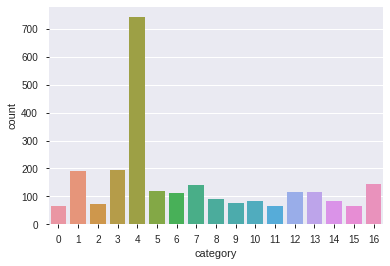

<IPython.core.display.Javascript object>

In [122]:
sns.countplot(x='category', data=df);

In [123]:
def make_category_map(labels):
    return {x: i for i, x in enumerate(set(labels))}

<IPython.core.display.Javascript object>

In [124]:
category_map = make_category_map(df["category"])
category_map

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16}

<IPython.core.display.Javascript object>

In [125]:
n_categories = len(category_map)
n_categories

17

<IPython.core.display.Javascript object>

In [126]:
df["category"] = df["category"].map(category_map)

<IPython.core.display.Javascript object>

In [127]:
df["category"].head()

0    15
1     6
2     6
3     6
4     6
Name: category, dtype: int64

<IPython.core.display.Javascript object>

In [128]:
data_container = DataContainer(
    *DataBundle.split(
        data_bundle=DataBundle.from_dataframe(
            dataframe=df, x_col="body", y_col="category"
        ),
        fracs=[0.8, 0.1, 0.1],
    )
)

<IPython.core.display.Javascript object>

In [129]:
len(data_container.train), len(data_container.validation), len(data_container.test)

(1983, 248, 247)

<IPython.core.display.Javascript object>

In [130]:
#TODO remove
class_weights = sk.utils.class_weight.compute_class_weight(
    "balanced", np.unique(data_container.train.y), data_container.train.y
)

<IPython.core.display.Javascript object>

In [131]:
def make_dataset(data_bundle):
    return tf.data.Dataset.from_tensor_slices((data_bundle.x, data_bundle.y))

<IPython.core.display.Javascript object>

In [132]:
for x, y in make_dataset(data_container.train).take(1):
    print(x)
    print(y)

tf.Tensor(b'Q: How many Oregonians does it take to screw in a light bulb?\nA: Five. One to change the bulb and four more to chase off the Californians who have come up to relate to the experience.\nA: Nine. One to change the bulb, and eight to protest the nuclear power plant that generates the electricity that powers it.', shape=(), dtype=string)
tf.Tensor(5, shape=(), dtype=int64)


<IPython.core.display.Javascript object>

In [133]:
data_container.train.dataset, data_container.validation.dataset, data_container.test.dataset = map(
    make_dataset, (data_container.train, data_container.validation, data_container.test)
)

<IPython.core.display.Javascript object>

In [134]:
def preprocess_batch(x, y, max_length=MAX_SEQUENCE_LENGTH):
    x = tf.strings.regex_replace(x, rb"<br\s*/?>", b" ")
    x = tf.strings.regex_replace(x, b"[^A-Za-z$\d]", b" ")
    x = tf.strings.lower(x)
    x = tf.strings.split(x)
    x = x.to_tensor(default_value=b"<pad>")
    paddings = tf.constant([[0, 0], [0, max_length]])
    x = tf.pad(x, paddings, constant_values=b"<pad>")
    x = x[:, :max_length]
    return x, y

<IPython.core.display.Javascript object>

In [135]:
for x, y in (
    data_container.train.dataset.batch(BATCH_SIZE).map(preprocess_batch).take(1)
):
    print(x.shape)
    print(y.shape)
    print(x[2])
    print(y[2])

(32, 500)
(32,)
tf.Tensor(
[b'tragically' b'three' b'friends' b'die' b'in' b'a' b'car' b'crash'
 b'and' b'they' b'find' b'themselves' b'at' b'the' b'gates' b'of'
 b'heaven' b'before' b'entering' b'they' b'are' b'each' b'asked' b'a'
 b'question' b'by' b'st' b'peter' b'when' b'you' b'are' b'in' b'your'
 b'casket' b'and' b'friends' b'and' b'family' b'are' b'mourning' b'upon'
 b'you' b'what' b'would' b'you' b'like' b'to' b'hear' b'them' b'say'
 b'about' b'you' b'asks' b'st' b'peter' b'the' b'first' b'guy' b'says'
 b'i' b'would' b'like' b'to' b'hear' b'them' b'say' b'that' b'i' b'was'
 b'a' b'great' b'doctor' b'of' b'my' b'time' b'and' b'a' b'great'
 b'family' b'man' b'the' b'second' b'guy' b'says' b'i' b'would' b'like'
 b'to' b'hear' b'that' b'i' b'was' b'a' b'wonderful' b'husband' b'and'
 b'school' b'teacher' b'who' b'made' b'a' b'huge' b'difference' b'in'
 b'our' b'children' b'of' b'tomorrow' b'the' b'last' b'guy' b'replies'
 b'i' b'would' b'like' b'to' b'hear' b'them' b'say' b'look' b'h

<IPython.core.display.Javascript object>

In [136]:
def make_vocabulary(dataset):
    vocabulary = Counter()
    for x, _ in dataset.batch(BATCH_SIZE).map(preprocess_batch):
        for review in x:
            vocabulary.update(review.numpy().tolist())
    return vocabulary

<IPython.core.display.Javascript object>

In [167]:
vocabulary = make_vocabulary(data_container.train.dataset)
len(vocabulary)

13780

<IPython.core.display.Javascript object>

In [182]:
VOCABULARY_SIZE = 13780  # using full vocab for now
truncated_vocabulary = [word for word, count in vocabulary.most_common(VOCABULARY_SIZE)]
n_oov_buckets = VOCABULARY_SIZE // 10

<IPython.core.display.Javascript object>

In [183]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)

<IPython.core.display.Javascript object>

In [184]:
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets=1)

<IPython.core.display.Javascript object>

In [185]:
def encode_words(x, y):
    return table.lookup(x), y

<IPython.core.display.Javascript object>

In [186]:
train_dataset = (
    data_container.train.dataset.batch(BATCH_SIZE)
    .map(preprocess_batch)
    .map(encode_words)
    .repeat()
    .prefetch(-1)
)

<IPython.core.display.Javascript object>

In [187]:
validation_dataset = (
    data_container.validation.dataset.batch(BATCH_SIZE)
    .map(preprocess_batch)
    .map(encode_words)
    .prefetch(-1)
)

<IPython.core.display.Javascript object>

In [174]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[2])
    print(y[2])

(32, 500)
(32,)
tf.Tensor(
[5571  107  410  723    9    2  136 1180    3   27  192 1649   31    1
  423    7  258  138 1872   27   36  205   62    2  355   66  199  160
   42    5   36    9   23 2012    3  410    3  386   36 2867  447    5
   24   63    5   78    4  298   74  133   60    5   89  199  160    1
   75   80   29    6   63   78    4  298   74  133   11    6   15    2
  203  116    7   34   83    3    2  203  386   28    1  139   80   29
    6   63   78    4  298   11    6   15    2  889   98    3  360  376
   82  207    2  579  862    9  145  455    7 1062    1  158   80  127
    6   63   78    4  298   74  133  149    8   14 1446    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0

<IPython.core.display.Javascript object>

In [175]:
train_dataset_steps = len(data_container.train) // BATCH_SIZE
validation_dataset_steps = len(data_container.validation) // BATCH_SIZE

<IPython.core.display.Javascript object>

In [146]:
def top_2_sparce_accuracy(y_true, y_pred):
    return keras.metrics.sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)

<IPython.core.display.Javascript object>

## Sequential Bidirectional LSTM model

In [147]:
model = keras.models.Sequential(
    [
        keras.layers.Embedding(
                VOCABULARY_SIZE + n_oov_buckets,
                EMBEDDING_DIM,
                mask_zero=True,
                input_shape=[None],
            ),
        keras.layers.Bidirectional(
            keras.layers.LSTM(64, dropout=0.2, return_sequences=True)
        ),
        keras.layers.Bidirectional(
            keras.layers.LSTM(64, dropout=0.2, return_sequences=True)
        ),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(n_categories, activation=keras.activations.softmax),
    ]
)

<IPython.core.display.Javascript object>

In [148]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[keras.metrics.sparse_categorical_accuracy, top_2_sparce_accuracy],
)

<IPython.core.display.Javascript object>

In [149]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=20,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ],
    class_weight=class_weights,
    verbose=2,
)

Train for 61 steps, validate for 7 steps
Epoch 1/20
61/61 - 22s - loss: 2.7202 - sparse_categorical_accuracy: 0.2690 - top_2_sparce_accuracy: 0.3499 - val_loss: 2.5545 - val_sparse_categorical_accuracy: 0.3036 - val_top_2_sparce_accuracy: 0.3750
Epoch 2/20
61/61 - 7s - loss: 2.5100 - sparse_categorical_accuracy: 0.3004 - top_2_sparce_accuracy: 0.3988 - val_loss: 2.4680 - val_sparse_categorical_accuracy: 0.3125 - val_top_2_sparce_accuracy: 0.4509
Epoch 3/20
61/61 - 7s - loss: 2.3243 - sparse_categorical_accuracy: 0.3480 - top_2_sparce_accuracy: 0.5156 - val_loss: 2.1840 - val_sparse_categorical_accuracy: 0.3750 - val_top_2_sparce_accuracy: 0.5312
Epoch 4/20
61/61 - 7s - loss: 1.9965 - sparse_categorical_accuracy: 0.4362 - top_2_sparce_accuracy: 0.5587 - val_loss: 2.0133 - val_sparse_categorical_accuracy: 0.4464 - val_top_2_sparce_accuracy: 0.5268
Epoch 5/20
61/61 - 7s - loss: 1.7132 - sparse_categorical_accuracy: 0.4962 - top_2_sparce_accuracy: 0.5736 - val_loss: 2.0012 - val_sparse_cat

<IPython.core.display.Javascript object>

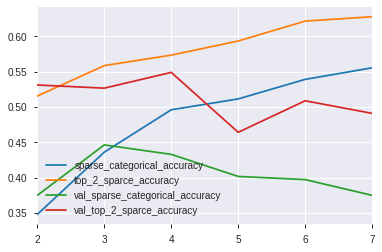

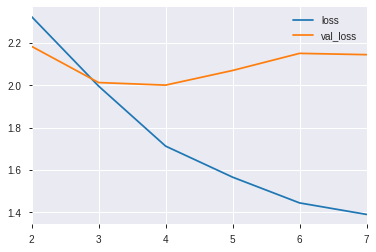

<IPython.core.display.Javascript object>

In [150]:
show_history(history, contains="acc", skip=2)
show_history(history, contains="loss", skip=2)

In [151]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

7/7 [==============================] - 0s 45ms/step - loss: 2.0012 - sparse_categorical_accuracy: 0.4330 - top_2_sparce_accuracy: 0.5491


[2.001236234392439, 0.4330357, 0.54910713]

<IPython.core.display.Javascript object>

In [152]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.09      0.24      0.13        17
           2       0.00      0.00      0.00         9
           3       0.94      0.85      0.89        20
           4       0.41      0.82      0.55        74
           5       0.73      1.00      0.84         8
           6       0.00      0.00      0.00        11
           7       0.93      1.00      0.96        13
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00        12
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         7
          16       0.09      0.06      0.07        16

    accuracy              

/home/martynas/ml/.venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<IPython.core.display.Javascript object>

## Use pre-trained GloVe vectors with Bidirectional LSTM

In [153]:
GLOVE_DIR = TEMP_DIR / f"glove.6B.{EMBEDDING_DIM}d.txt"
embeddings_index = {}
f = open(GLOVE_DIR, encoding="utf-8")
print("Loading GloVe from:", GLOVE_DIR, "...", end=" ")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype="float32")
f.close()
print("Done.")

Loading GloVe from: temp/glove.6B.200d.txt ... Done.


<IPython.core.display.Javascript object>

In [188]:
unknown_word_count = 0
embedding_matrix = np.random.random((len(truncated_vocabulary) + 1, EMBEDDING_DIM))
for i, word in enumerate(truncated_vocabulary):
    embedding_vector = embeddings_index.get(word.decode("utf-8"))
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        unknown_word_count += 1
        if unknown_word_count < 10:
            print(word.decode("utf-8"))
print("Completed!")
print(unknown_word_count)

<pad>
poopie
$5
$100
$50
myass
$20
$500
rindercella
Completed!
1170


<IPython.core.display.Javascript object>

In [189]:
embedding_matrix.shape

(13781, 200)

<IPython.core.display.Javascript object>

In [190]:
model = keras.models.Sequential(
    [
        keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32"),
        keras.layers.Embedding(
            len(truncated_vocabulary) + 1,
            EMBEDDING_DIM,
            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=False,
            name="embeddings",
        ),
        keras.layers.Bidirectional(
            keras.layers.LSTM(64, dropout=0.2, return_sequences=True)
        ),
        keras.layers.Bidirectional(
            keras.layers.LSTM(64, dropout=0.2, return_sequences=True)
        ),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(n_categories, activation=keras.activations.softmax),
    ]
)

<IPython.core.display.Javascript object>

In [191]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[keras.metrics.sparse_categorical_accuracy, top_2_sparce_accuracy],
)

<IPython.core.display.Javascript object>

In [192]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 500, 200)          2756200   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 500, 128)          135680    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 500, 128)          98816     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 128)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 17)                2193      
Total params: 2,992,889
Trainable params: 236,689
Non-trainable params: 2,756,200
______________________________________

<IPython.core.display.Javascript object>

In [193]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=20,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ],
    class_weight=class_weights,
    verbose=2,
)

Train for 61 steps, validate for 7 steps
Epoch 1/20
61/61 - 10s - loss: 2.6345 - sparse_categorical_accuracy: 0.2454 - top_2_sparce_accuracy: 0.3299 - val_loss: 2.4629 - val_sparse_categorical_accuracy: 0.3036 - val_top_2_sparce_accuracy: 0.4509
Epoch 2/20
61/61 - 6s - loss: 2.4822 - sparse_categorical_accuracy: 0.2932 - top_2_sparce_accuracy: 0.4300 - val_loss: 2.3630 - val_sparse_categorical_accuracy: 0.3036 - val_top_2_sparce_accuracy: 0.4643
Epoch 3/20
61/61 - 6s - loss: 2.3730 - sparse_categorical_accuracy: 0.3055 - top_2_sparce_accuracy: 0.4546 - val_loss: 2.2481 - val_sparse_categorical_accuracy: 0.3705 - val_top_2_sparce_accuracy: 0.5089
Epoch 4/20
61/61 - 6s - loss: 2.2299 - sparse_categorical_accuracy: 0.3685 - top_2_sparce_accuracy: 0.5151 - val_loss: 2.0883 - val_sparse_categorical_accuracy: 0.4241 - val_top_2_sparce_accuracy: 0.5268
Epoch 5/20
61/61 - 6s - loss: 2.0515 - sparse_categorical_accuracy: 0.4264 - top_2_sparce_accuracy: 0.5572 - val_loss: 1.9542 - val_sparse_cat

<IPython.core.display.Javascript object>

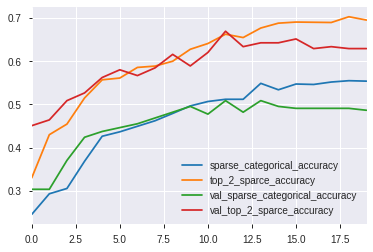

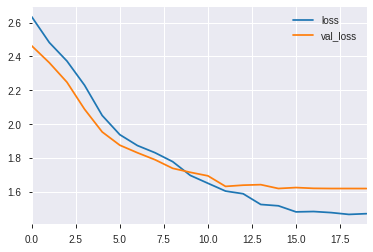

<IPython.core.display.Javascript object>

In [197]:
show_history(history, contains="acc")
show_history(history, contains="loss")

### Finetuning

In [199]:
for layer in model.layers:
    layer.trainable = True

<IPython.core.display.Javascript object>

In [204]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[keras.metrics.sparse_categorical_accuracy, top_2_sparce_accuracy],
)

<IPython.core.display.Javascript object>

In [205]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=10,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ],
    class_weight=class_weights,
    verbose=2,
)

Train for 61 steps, validate for 7 steps
Epoch 1/10
61/61 - 13s - loss: 1.4093 - sparse_categorical_accuracy: 0.5615 - top_2_sparce_accuracy: 0.7059 - val_loss: 1.5702 - val_sparse_categorical_accuracy: 0.5223 - val_top_2_sparce_accuracy: 0.6384
Epoch 2/10
61/61 - 6s - loss: 1.3855 - sparse_categorical_accuracy: 0.5720 - top_2_sparce_accuracy: 0.7207 - val_loss: 1.5673 - val_sparse_categorical_accuracy: 0.5223 - val_top_2_sparce_accuracy: 0.6384
Epoch 3/10
61/61 - 6s - loss: 1.3520 - sparse_categorical_accuracy: 0.5828 - top_2_sparce_accuracy: 0.7314 - val_loss: 1.5435 - val_sparse_categorical_accuracy: 0.5179 - val_top_2_sparce_accuracy: 0.6562
Epoch 4/10
61/61 - 6s - loss: 1.3381 - sparse_categorical_accuracy: 0.5900 - top_2_sparce_accuracy: 0.7330 - val_loss: 1.5396 - val_sparse_categorical_accuracy: 0.5312 - val_top_2_sparce_accuracy: 0.6473
Epoch 5/10
61/61 - 6s - loss: 1.3107 - sparse_categorical_accuracy: 0.5869 - top_2_sparce_accuracy: 0.7417 - val_loss: 1.5178 - val_sparse_cat

<IPython.core.display.Javascript object>

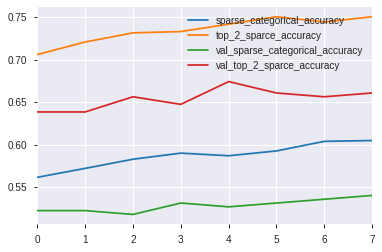

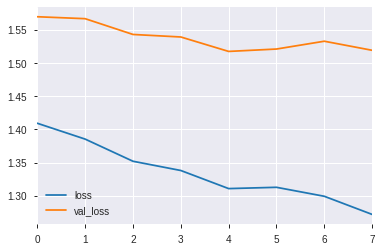

<IPython.core.display.Javascript object>

In [206]:
show_history(history, contains="acc")
show_history(history, contains="loss")

In [207]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

7/7 [==============================] - 0s 40ms/step - loss: 1.5178 - sparse_categorical_accuracy: 0.5268 - top_2_sparce_accuracy: 0.6741


[1.5178279025214059, 0.52678573, 0.67410713]

<IPython.core.display.Javascript object>

In [208]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.50      0.11      0.18         9
           1       0.12      0.12      0.12        17
           2       0.00      0.00      0.00         9
           3       1.00      0.90      0.95        20
           4       0.48      0.82      0.61        74
           5       0.89      1.00      0.94         8
           6       0.91      0.91      0.91        11
           7       1.00      1.00      1.00        13
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00         9
          12       0.25      0.50      0.33         6
          13       0.50      0.58      0.54        12
          14       0.17      0.11      0.13         9
          15       1.00      0.14      0.25         7
          16       0.24      0.25      0.24        16

    accuracy              

/home/martynas/ml/.venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<IPython.core.display.Javascript object>